In [551]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [552]:
import time

In [553]:
t = time.time()

In [554]:
from sklearn.preprocessing import LabelEncoder

In [555]:
from torch.nn.utils.rnn import pad_sequence

In [556]:
from gensim.models import Word2Vec

In [557]:
stopwords = stopwords.words('russian')

In [558]:
df = pd.read_csv('./data/Petitions.csv')

In [559]:
print(len(df['reason_category'].unique()))

15


In [560]:
df.drop(columns="id", inplace=True)

In [561]:
new_df = df.sample(1000)

In [562]:
rep = new_df["public_petition_text"].to_list()

In [563]:
rep

['Здравствуйте! Прошу вас уберите пожалуйста мусор с газона. Спасибо',
 'реклама так и висит',
 'Необходимо провести профилактическую дератизацию подвалов, мусоросборочных боксов, подъездов, чердаков, технических помещений данного МКД (С 1 по 4 подъезд). Дело в том, что из подвала слышны писки крыс, из мусоропровода постоянное шуршание идёт, характерное для данных грызунов.  Нужно срочно принимать меры, пока это снова не стало масштабным бедствием по всему дому.',
 'Мусор вокруг дома\nРастаял снег  и видно , что двор давно не убирается.',
 'Неудовлетворительный окрас фасада домов',
 'Не светит (https://gorod.gov.spb.ru/problems/3215483/)',
 'постоянно не вывозят мусор контейнер один на большое количество домов.необхожимл привести в порядок',
 'Не работает освещение на крыльце',
 'отсутствует заглушка подоконника в холле МОП сразу после входной двери. "УК Комфорт сервис" не производит ремонт.',
 'По адресу город пушкин, кадетский бульвар 22А по левую и правую сторону от входа в библиоте

In [564]:
def remove_html(text): 
    html_tag=re.compile('<.*?>')
    text_no_html = html_tag.sub('', text)
    return text_no_html

In [565]:
def remove_quots(text):
    text_only_letters = re.sub('[^\w\s]', '', text)
    return text_only_letters


In [566]:
def tokenize(text):
    words = word_tokenize(text)
    return words


In [567]:
ts = time.time()
for i in rep:
    print(time.time() - t)

0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.639855146408081
0.63985514

In [568]:
morphs = MorphAnalyzer()
def morph(text):
    # print(type(text))
    # for w in text:
        # print(1)
        # morph.normal_forms(w)[0]
        # print(w, time.time() - ts)
    lemmas = [morphs.normal_forms(w)[0] for w in text]
    return lemmas

In [569]:
def del_sw(text):
    prepared = [w for w in text if w not in stopwords]
    lemm_sentce = ' '.join(prepared)
    return lemm_sentce

In [570]:
general_mass = {
    "rem_html" : remove_html,
    "rem_quots" : remove_quots,
    "tokenize" : tokenize,
    "morph" : morph,
    "del_sw" : del_sw
}

In [571]:
list_m = ["rem_html", "rem_quots", "tokenize", "morph", "del_sw"]

In [572]:
def prepro(list_m, text):
    for i in list_m:
        text = [general_mass[i](j) for j in text]
    return text

In [573]:
prepro_text = prepro(list_m=list_m, text=rep)

In [574]:
prepro_text

['здравствуйте просить убрать пожалуйста мусор газон спасибо',
 'реклама висеть',
 'необходимо провести профилактический дератизация подвал мусоросборочный бокс подъезд чердак технический помещение данный мкд 1 4 подъезд дело подвал слышный писк крыса мусоропровод постоянный шуршание идти характерный данные грызун нужно срочно принимать мера пока это снова стать масштабный бедствие весь дом',
 'мусор вокруг дом растаять снег видно двор давно убираться',
 'неудовлетворительный окрас фасад дом',
 'светить httpsgorodgovspbruproblems3215483',
 'постоянно вывозить мусор контейнер большой количество домовнеобхожимл привести порядок',
 'работать освещение крыльцо',
 'отсутствовать заглушка подоконник холл моп сразу входной дверь ук комфорт сервис производить ремонт',
 'адрес город пушкин кадетский бульвар 22а левый правый сторона вход библиотека находиться крупногабаритный мусор крупный мешок листва который убирать ещё осень мешок вывезти также газон иметься пакет мелкий бытовой мусор окно жи

In [575]:
count_vocab = set(' '.join(prepro_text).split())

In [576]:
count_vocab.add("<pad>")

In [577]:
l_c_v = list(count_vocab)

In [578]:
if "<pad>" in count_vocab:
    print("Элемент найден")
    print(l_c_v.index("<pad>"))
else:
    print("Элемент не найден")

Элемент найден
2442


In [579]:
word_to_ix = {word: i for i, word in enumerate(count_vocab)}
word_list = list(word_to_ix.keys())
word_list 

['необходимость',
 'повторно',
 'лёд',
 'согласованность',
 'обязать',
 'типанов',
 '30318833',
 'врач',
 'суббота',
 'потечь',
 'устранить',
 'опухнуть',
 'измазать',
 'фрагмент',
 'ледяной',
 'соответствие',
 'тупиковый',
 'краска',
 'уборщица',
 'концентрация',
 'недопустимо',
 'обеспечение',
 'подножка',
 '60008978',
 'параднаян',
 '5м',
 'роспотребнадзор',
 'давно',
 'ополчение',
 'старокрасносельский',
 'ольминский',
 'изрыть',
 'пропаганда',
 'прекращаться',
 'покрытие',
 'просадка',
 'жилищный',
 'пожалуйста',
 'видимость',
 'пролежать',
 'помещение',
 '240321',
 'отремонтировать',
 'слив',
 'некрасовский',
 'водитель',
 'территория',
 'комитет',
 'соблюдаться',
 '1401',
 '02122002',
 'терраса',
 'роллставень',
 'замер',
 'приехать',
 'проживание',
 'клетка',
 'применение',
 'действие',
 'профессиональный',
 'камера',
 '287',
 'садик',
 'сделанон',
 'массово',
 'хотеть',
 'чтонибыть',
 'аварийный',
 'ростовский',
 'внутриквартальный',
 'закрашивание',
 'отвратительный',
 'целик

In [580]:
word_to_ix["<pad>"]

2442

In [581]:
AA = list(map(lambda x: list(map(lambda a: word_to_ix[a], x.split(' '))), prepro_text))
word_list_tensor = list(map(lambda x: torch.tensor(x), AA))
word_list_tensor

[tensor([2229,  570,  706,   37, 1492,  884,  532]),
 tensor([2104, 1869]),
 tensor([2206,  472, 2323, 2238, 2723, 2709, 1468, 1729,  670, 1973,   40, 2840,
         1547,  604, 1955, 1729, 2560, 2723, 1894, 2316, 2483, 1290, 2861, 1902,
         1756, 2253,  319,  259,  263, 2399, 2484,  360, 2132, 1141, 2264, 1007,
          928,  103,  190, 2551]),
 tensor([1492, 2147, 2551, 2302, 1727, 2072,  381,   27, 1583]),
 tensor([ 116, 2651, 2542, 2551]),
 tensor([1735,  158]),
 tensor([2035, 2845, 1492,  819, 2734, 2665, 2658, 1591, 1408]),
 tensor([ 501, 1201, 1707]),
 tensor([1600, 1127, 1843, 2204, 1578,  175,  637, 1261, 1548, 1980, 2174,  700,
         1107]),
 tensor([2080,  292, 1038,  516, 1906, 2480, 1179, 2620, 1003, 2633, 2092,  713,
         2531, 1492,  235,  835, 1028, 1073, 1682,   75,  475,  835, 2036, 1553,
          884, 2529, 1273,  459, 1750, 1492,  934,  351,   40,  190, 2005,   98,
          713, 1003, 2853,  516, 1906, 1909, 2633, 2092, 1141, 2382,   46]),
 tensor([14

In [582]:
len(word_list_tensor)

1000

In [583]:
w2v = Word2Vec(sentences=word_list, min_count=1, vector_size=32, epochs=50)

In [584]:
w2v.wv.vectors

array([[-2.4246280e-01, -6.2252522e-02,  2.4312302e-01, ...,
        -1.3907178e-01, -6.6197932e-01, -7.0422918e-01],
       [ 1.8513414e-01, -1.4158992e-01,  3.5583737e-01, ...,
        -2.0473613e-01, -3.6513427e-01, -6.8183136e-01],
       [-3.5869300e-01, -7.3778935e-02,  3.9941683e-01, ...,
        -3.8989797e-01,  4.2647654e-01, -5.2523720e-01],
       ...,
       [-4.8500396e-02, -2.7669662e-01,  1.2547147e-01, ...,
        -4.7045648e-02, -4.9719698e-04,  2.4754807e-01],
       [-5.4540511e-02, -7.2303906e-02,  1.8474959e-01, ...,
        -2.0852013e-01, -1.0937165e-01, -3.5973798e-02],
       [-9.1420546e-02, -2.8256339e-01,  1.7929961e-01, ...,
        -6.8439640e-02, -5.4570362e-02,  2.3942024e-01]], dtype=float32)

In [585]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(new_df["reason_category"])

In [586]:
X_pad = pad_sequence(word_list_tensor, batch_first=True, padding_value=word_to_ix["<pad>"])

In [587]:
len(X_pad[0])

147

In [588]:
X_pad

tensor([[2229,  570,  706,  ..., 2442, 2442, 2442],
        [2104, 1869, 2442,  ..., 2442, 2442, 2442],
        [2206,  472, 2323,  ..., 2442, 2442, 2442],
        ...,
        [2836, 1056,  209,  ..., 2442, 2442, 2442],
        [1499,  604, 1134,  ..., 2442, 2442, 2442],
        [2210, 1707, 1499,  ..., 2442, 2442, 2442]])

In [589]:
# # X_pad_new = X_pad
X_pad_new = torch.tensor([reversed(i).numpy() for i in X_pad])
X_pad_new 

tensor([[2442, 2442, 2442,  ...,  706,  570, 2229],
        [2442, 2442, 2442,  ..., 2442, 1869, 2104],
        [2442, 2442, 2442,  ..., 2323,  472, 2206],
        ...,
        [2442, 2442, 2442,  ...,  209, 1056, 2836],
        [2442, 2442, 2442,  ..., 1134,  604, 1499],
        [2442, 2442, 2442,  ..., 1499, 1707, 2210]])

In [590]:
X_pad.shape

torch.Size([1000, 147])

In [591]:
y.shape

(1000,)

In [592]:
# embedding = nn.Embedding(10, 3)
# input = torch.LongTensor([[0, 2, 0, 5]])
# embedding(input)

In [593]:
X_train, X_test, y_train, y_test = train_test_split(X_pad_new, y, test_size=0.2, random_state=42)

In [594]:
batch_size = 256
train_ds = TensorDataset(X_train, torch.from_numpy(y_train).type(torch.long))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [595]:
x_c, y_c = next(iter(train_dl))
x_c.shape, y_c.shape

(torch.Size([256, 147]), torch.Size([256]))

In [596]:
embed_len = 256
hidden_dim = 100
n_layers=1

In [597]:
import torch.nn.functional as F

In [598]:
class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(count_vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.tnh = nn.Tanh()
        self.linear = nn.Linear(hidden_dim, 15)
        self.smax = nn.Softmax(dim=1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        # print(embeddings.shape, "EMB")
        output1, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim))
        output2 = self.tnh(output1)
        # print(output2.size(), "OU2")
        output2 = self.linear(hidden.squeeze(0))
        # print(output2.shape, "OUT3")
        return self.smax(output2)

In [599]:
model = RNNClassifier()

In [600]:
model(next(iter(train_dl))[0])

tensor([[0.0536, 0.0795, 0.0350,  ..., 0.0623, 0.0349, 0.0540],
        [0.0391, 0.0404, 0.0537,  ..., 0.0501, 0.0988, 0.0776],
        [0.0674, 0.0862, 0.0376,  ..., 0.0321, 0.1391, 0.0827],
        ...,
        [0.0555, 0.0542, 0.0366,  ..., 0.0552, 0.0700, 0.0767],
        [0.0502, 0.0574, 0.0504,  ..., 0.0637, 0.0591, 0.0592],
        [0.0408, 0.1814, 0.0679,  ..., 0.0555, 0.0550, 0.0663]],
       grad_fn=<SoftmaxBackward0>)

In [601]:
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

In [602]:
loss_function = nn.CrossEntropyLoss(ignore_index=word_to_ix["<pad>"])

In [603]:
# m = nn.Softmax(dim=1)
# input = torch.randn(2, 3)
# print(input)
# output = m(input)
# print(output)

In [604]:
epochs = 25

loss_values = []
for epoch in range(epochs):
    for x_b, y_b in train_dl:
        outputs = model(x_b)
        loss_value = loss_function(outputs, y_b)

        loss_value.backward()

        optimizer.step()

        optimizer.zero_grad()
    loss_values.append(loss_value.item())

    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

Эпоха 1, Значение функции потерь: 2.713927745819092
Эпоха 2, Значение функции потерь: 2.7043685913085938
Эпоха 3, Значение функции потерь: 2.7084734439849854
Эпоха 4, Значение функции потерь: 2.69852352142334
Эпоха 5, Значение функции потерь: 2.7019076347351074
Эпоха 6, Значение функции потерь: 2.6873040199279785
Эпоха 7, Значение функции потерь: 2.6966805458068848
Эпоха 8, Значение функции потерь: 2.6893362998962402
Эпоха 9, Значение функции потерь: 2.6866283416748047
Эпоха 10, Значение функции потерь: 2.666456699371338
Эпоха 11, Значение функции потерь: 2.6880929470062256
Эпоха 12, Значение функции потерь: 2.6518328189849854
Эпоха 13, Значение функции потерь: 2.653718948364258
Эпоха 14, Значение функции потерь: 2.6310970783233643
Эпоха 15, Значение функции потерь: 2.6414456367492676
Эпоха 16, Значение функции потерь: 2.667264938354492
Эпоха 17, Значение функции потерь: 2.6038053035736084
Эпоха 18, Значение функции потерь: 2.6208155155181885
Эпоха 19, Значение функции потерь: 2.562624

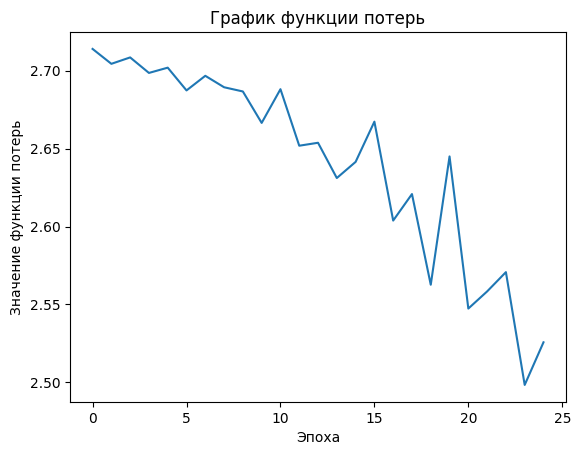

In [605]:
plt.plot(loss_values)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь')
plt.show()

In [606]:
y_pred = model(X_test)
y_pred

tensor([[0.0963, 0.0298, 0.0715,  ..., 0.0495, 0.0512, 0.0655],
        [0.0798, 0.0445, 0.0722,  ..., 0.0611, 0.0688, 0.0643],
        [0.1356, 0.0350, 0.0985,  ..., 0.0662, 0.0641, 0.0713],
        ...,
        [0.0409, 0.0747, 0.0265,  ..., 0.0858, 0.0512, 0.0389],
        [0.0938, 0.0468, 0.0233,  ..., 0.0534, 0.0680, 0.0361],
        [0.4280, 0.0347, 0.0244,  ..., 0.0156, 0.0286, 0.0416]],
       grad_fn=<SoftmaxBackward0>)

In [607]:
# y_pred_soft = F.softmax(y_pred, dim=-1)
# y_pred_soft

In [608]:
y_pred_arg = [torch.argmax(pred, dim=0).numpy() for pred in y_pred]

In [609]:
y_pred_arg

[array(11, dtype=int64),
 array(11, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(11, dtype=int64),
 array(9, dtype=int64),
 array(0, dtype=int64),
 array(11, dtype=int64),
 array(11, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(5, dtype=int64),
 array(4, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(11, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(9, dtype=int64),
 array(11, dtype=int64),
 array(11, dtype=int64),
 array(13, dtype=int64),
 array(0, dtype=int64),
 array(9, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(

In [610]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_arg)) 

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       119
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.20      0.11      0.14         9
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.44      0.41      0.42        44
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         1

    accuracy                           0.49       200
   macro avg       0.09      0.08      0.08       200
weighted avg       0.53   

d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.

## GRU


In [611]:
class GRUClassifier(nn.Module):
    def __init__(self):
        super(GRUClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(count_vocab), embedding_dim=embed_len)
        self.gru = nn.GRU(input_size=embed_len,  hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 15)

    def forward(self, X_batch):
        
        embeddings = self.embedding_layer(X_batch)
        # print(embeddings.size(), "emb")
        output1, hidden = self.gru(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim))
        # print(hidden.size(), "HIDDEN")
        # print(output1.size(), "OUT1")
        # output2 = self.linear(output1)
        return self.linear(hidden.squeeze(0))

In [612]:
model2 = GRUClassifier()

In [613]:
model2

GRUClassifier(
  (embedding_layer): Embedding(2888, 256)
  (gru): GRU(256, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=15, bias=True)
)

In [614]:
model2(next(iter(train_dl))[0])

tensor([[ 0.0029,  0.3150,  0.0328,  ..., -0.4454, -0.2937,  0.0171],
        [-0.3612,  0.2133,  0.4300,  ..., -0.1014, -0.0093, -0.1514],
        [ 0.4300,  0.0557,  0.1336,  ..., -0.1103, -0.0506, -0.2195],
        ...,
        [-0.2766,  0.1180, -0.2115,  ...,  0.0775, -0.1292, -0.2974],
        [-0.4388,  0.0229, -0.2125,  ...,  0.0005,  0.1387, -0.1716],
        [ 0.1187, -0.2666, -0.0953,  ...,  0.2102,  0.2239, -0.0310]],
       grad_fn=<AddmmBackward0>)

In [615]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr= 1e-4)
loss_function2 = nn.CrossEntropyLoss(ignore_index=word_to_ix["<pad>"])

In [616]:
epochs = 25
loss_values2 = []
for epoch in range(epochs):
    for x_b, y_b in train_dl:
        outputs2 = model2(x_b)
        # print(outputs2.shape)
        loss_value2 = loss_function2(outputs2, y_b)

        loss_value2.backward()

        optimizer2.step()

        optimizer2.zero_grad()
    loss_values2.append(loss_value2.item())

    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value2.item()}')

Эпоха 1, Значение функции потерь: 2.6703438758850098
Эпоха 2, Значение функции потерь: 2.5421648025512695
Эпоха 3, Значение функции потерь: 2.6323940753936768
Эпоха 4, Значение функции потерь: 2.5259130001068115
Эпоха 5, Значение функции потерь: 2.2790069580078125
Эпоха 6, Значение функции потерь: 2.3504316806793213
Эпоха 7, Значение функции потерь: 2.263275623321533
Эпоха 8, Значение функции потерь: 2.207519769668579
Эпоха 9, Значение функции потерь: 2.191526174545288
Эпоха 10, Значение функции потерь: 2.320965528488159
Эпоха 11, Значение функции потерь: 2.2442078590393066
Эпоха 12, Значение функции потерь: 2.204653263092041
Эпоха 13, Значение функции потерь: 2.150940418243408
Эпоха 14, Значение функции потерь: 2.3107457160949707
Эпоха 15, Значение функции потерь: 1.9018843173980713
Эпоха 16, Значение функции потерь: 2.056104898452759
Эпоха 17, Значение функции потерь: 1.9264709949493408
Эпоха 18, Значение функции потерь: 1.7040311098098755
Эпоха 19, Значение функции потерь: 1.8616461

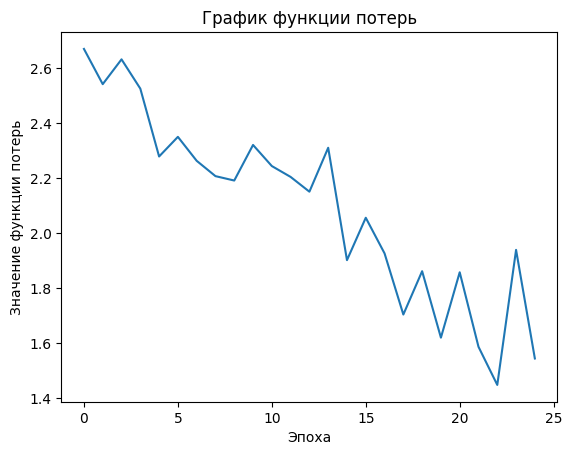

In [617]:
plt.plot(loss_values2)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь')
plt.show()

In [618]:
y_pred2 = model2(X_test)
y_pred2

tensor([[ 1.7203, -0.6936, -0.3206,  ..., -0.1452, -0.0610, -0.5268],
        [ 1.9844, -0.8967, -0.5899,  ..., -0.2500,  0.1973, -0.4494],
        [ 1.8868, -0.3630, -0.1281,  ..., -0.2460, -0.5390, -0.5399],
        ...,
        [ 0.3673,  0.1922, -0.1736,  ..., -0.8147, -0.3432, -0.1886],
        [ 0.6715,  0.0416, -0.4124,  ..., -0.6146, -0.4281, -0.3732],
        [ 2.7074, -1.0212, -0.6754,  ..., -0.4911, -0.0592, -0.6992]],
       grad_fn=<AddmmBackward0>)

In [619]:
y_pred_arg2 = [torch.argmax(pred2, dim=0).numpy() for pred2 in y_pred2]

In [620]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_arg2)) 

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       119
           1       0.00      0.00      0.00         1
           2       1.00      0.20      0.33         5
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.71      0.45      0.56        44
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         1

    accuracy                           0.64       200
   macro avg       0.17      0.11      0.12       200
weighted avg       0.59      0.64      0.59       200



d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.

In [621]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(count_vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len,  hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 15)

    def forward(self, X_batch):
        
        embeddings = self.embedding_layer(X_batch)
        # print(embeddings.shape, "EMB")
        output1, (hidden, c) = self.lstm(embeddings, (torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)))
        # print(hidden.size(), "HIDDEN")
        # print(output1[:, -1], "OUT1")
        # print(output1.shape, "OUT1")
        output2 = self.linear(output1)
        # print(output2.shape, "OUT2")
        return self.linear(hidden.squeeze(0))

In [622]:
model3 = LSTMClassifier()

In [623]:
model3

LSTMClassifier(
  (embedding_layer): Embedding(2888, 256)
  (lstm): LSTM(256, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=15, bias=True)
)

In [624]:
model3(next(iter(train_dl))[0])

tensor([[-0.1313,  0.2389, -0.0681,  ...,  0.0203, -0.0529, -0.0551],
        [ 0.1646,  0.0989, -0.0325,  ..., -0.3080, -0.1252, -0.0456],
        [-0.0335,  0.2292,  0.1209,  ...,  0.1762,  0.0304,  0.0731],
        ...,
        [ 0.0832,  0.2224, -0.0812,  ...,  0.1643, -0.0901, -0.1680],
        [-0.2177,  0.2744, -0.1243,  ...,  0.0964, -0.0855, -0.0164],
        [-0.0724,  0.0990,  0.0222,  ..., -0.1666,  0.1050, -0.0213]],
       grad_fn=<AddmmBackward0>)

In [625]:
optimizer3 = torch.optim.Adam(model3.parameters(), lr= 1e-4)
loss_function3 = nn.CrossEntropyLoss(ignore_index=word_to_ix["<pad>"])

In [626]:
epochs = 20

loss_values3 = []
for epoch in range(epochs):
    for x_b, y_b in train_dl:
        outputs3 = model3(x_b)
        # print(outputs2.shape)
        loss_value3 = loss_function3(outputs3, y_b)

        loss_value3.backward()

        optimizer3.step()

        optimizer3.zero_grad()
    loss_values3.append(loss_value3.item())

    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value3.item()}')

Эпоха 1, Значение функции потерь: 2.7009570598602295
Эпоха 2, Значение функции потерь: 2.6758482456207275
Эпоха 3, Значение функции потерь: 2.619051456451416
Эпоха 4, Значение функции потерь: 2.570729970932007
Эпоха 5, Значение функции потерь: 2.5203745365142822
Эпоха 6, Значение функции потерь: 2.5255491733551025
Эпоха 7, Значение функции потерь: 2.4761805534362793
Эпоха 8, Значение функции потерь: 2.5164172649383545
Эпоха 9, Значение функции потерь: 2.450336456298828
Эпоха 10, Значение функции потерь: 2.3798985481262207
Эпоха 11, Значение функции потерь: 2.3340628147125244
Эпоха 12, Значение функции потерь: 2.229839563369751
Эпоха 13, Значение функции потерь: 2.181349039077759
Эпоха 14, Значение функции потерь: 2.1378087997436523
Эпоха 15, Значение функции потерь: 2.2958147525787354
Эпоха 16, Значение функции потерь: 2.268181800842285
Эпоха 17, Значение функции потерь: 2.110790491104126
Эпоха 18, Значение функции потерь: 2.097715139389038
Эпоха 19, Значение функции потерь: 1.92414915

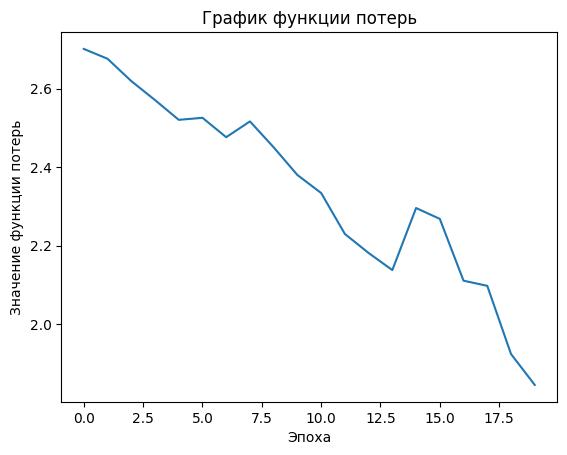

In [627]:
plt.plot(loss_values3)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь')
plt.show()

In [628]:
y_pred3 = model3(X_test)
y_pred3

tensor([[ 1.3533e+00, -2.0997e-01, -1.8944e-01,  ..., -2.9099e-01,
         -3.7318e-01, -1.7596e-01],
        [ 1.4093e+00, -3.0567e-01, -3.6019e-01,  ..., -3.2583e-01,
         -4.6226e-01, -3.9035e-01],
        [ 1.2943e+00, -3.5350e-01, -1.9786e-01,  ..., -1.2162e-01,
         -4.2836e-01, -4.4473e-01],
        ...,
        [ 1.1432e-01, -1.8567e-02, -1.8269e-01,  ...,  6.6904e-04,
         -1.6236e-01, -2.5382e-01],
        [ 3.3443e-01,  8.4467e-03, -3.3089e-01,  ..., -1.4794e-01,
         -1.0700e-01, -2.2251e-01],
        [ 2.0456e+00, -3.7995e-01, -4.7740e-01,  ..., -3.0811e-01,
         -5.3083e-01, -3.7262e-01]], grad_fn=<AddmmBackward0>)

In [629]:
y_pred_arg3 = [torch.argmax(pred3, dim=0).numpy() for pred3 in y_pred3]

In [630]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_arg3)) 

              precision    recall  f1-score   support

           0       0.67      0.92      0.77       119
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.50      0.11      0.18         9
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.79      0.34      0.48        44
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         1

    accuracy                           0.62       200
   macro avg       0.14      0.10      0.10       200
weighted avg       0.59      0.62      0.57       200



d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\NLP_5_sem\venv_nlp\Lib\site-packages\sklearn\metrics\_classification.